In [877]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams["figure.facecolor"] = 'FFFFFF'
matplotlib.rcParams['figure.dpi'] = 100

In [823]:
original_data = pd.read_excel('online_retail_II.xlsx', [0, 1])
original_data = pd.concat([original_data[0], original_data[1]], ignore_index=True)

In [865]:
data = original_data.copy()

In [866]:
data['Cancelled'] = (original_data['Invoice'].str[0] == 'C')
data.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Cancelled'],
      dtype='object')

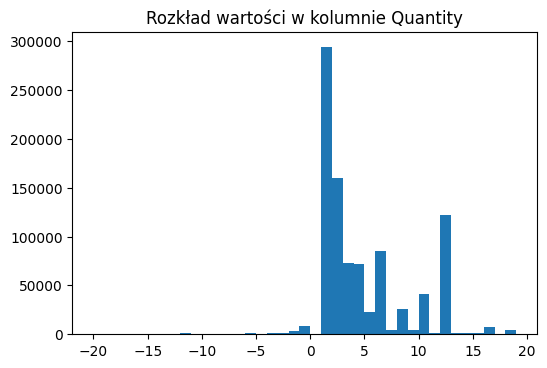

In [867]:
plt.hist(data['Quantity'], bins=list(range(-20, 20, 1)))
plt.title("Rozkład wartości w kolumnie Quantity");

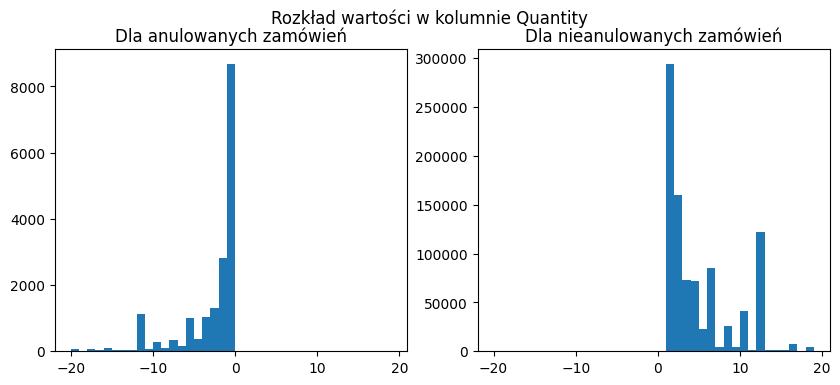

In [868]:
_, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("Rozkład wartości w kolumnie Quantity")
axes[0].set_title("Dla anulowanych zamówień")
axes[0].hist(data[data['Cancelled']]['Quantity'], bins=list(range(-20, 20, 1)));

axes[1].set_title("Dla nieanulowanych zamówień")
axes[1].hist(data[~data['Cancelled']]['Quantity'], bins=list(range(-20, 20, 1)));

In [869]:
data['Quantity'] = data['Quantity'].abs()

In [870]:
data.isna().any()

Invoice        False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
Price          False
Customer ID     True
Country        False
Cancelled      False
dtype: bool

In [871]:
nan_number = data['Customer ID'].isna().value_counts()[True]
data[data['Customer ID'].isna()]['Customer ID'] = -1
print(f"Replaced {nan_number} NaNs with -1")

Replaced 243007 NaNs with -1


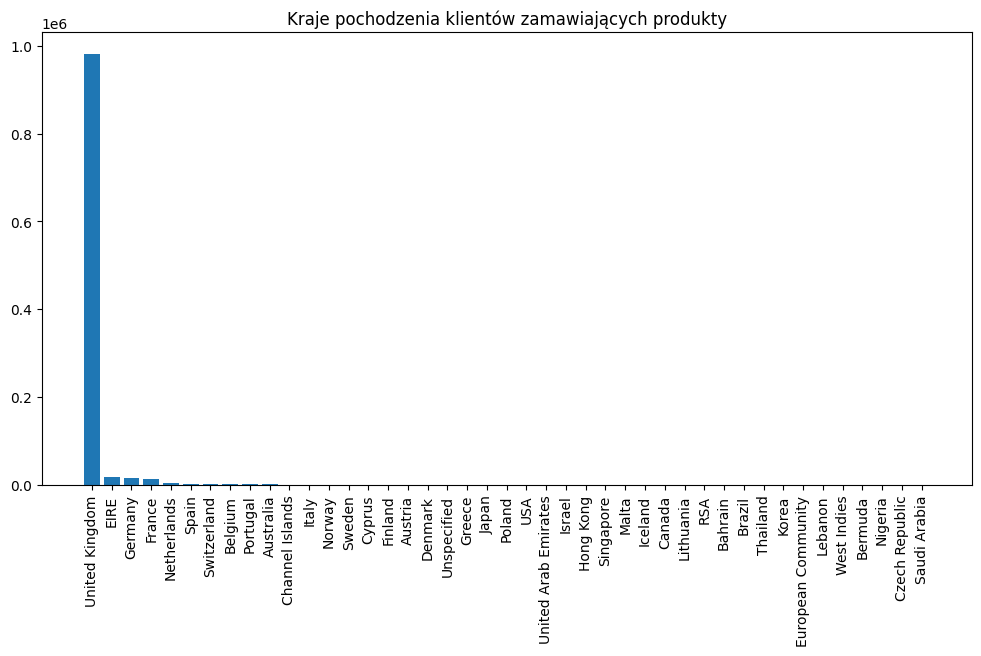

In [883]:
countries = data['Country'].value_counts().to_dict()
plt.figure(figsize=(12, 6))
plt.bar(list(countries.keys()), height=list(countries.values()))
plt.xticks(*plt.xticks(), rotation=90)
plt.title("Kraje pochodzenia klientów zamawiających produkty");

In [849]:
duplicate_amounts = [0 for _ in range(30)]

for group_name, group in data.groupby(by=['StockCode', 'Quantity', 'Price', 'Customer ID']):
    if True in group['Cancelled'].values:
        try:
            not_cancelled = group['Cancelled'].value_counts()[False]
        except KeyError:
            not_cancelled = 0
        while len(duplicate_amounts) <= not_cancelled:
            duplicate_amounts.append(0)
        duplicate_amounts[not_cancelled] += group['Cancelled'].value_counts()[True]

0.381 z anulowanych produktów ma nieanulowany odpowiednik


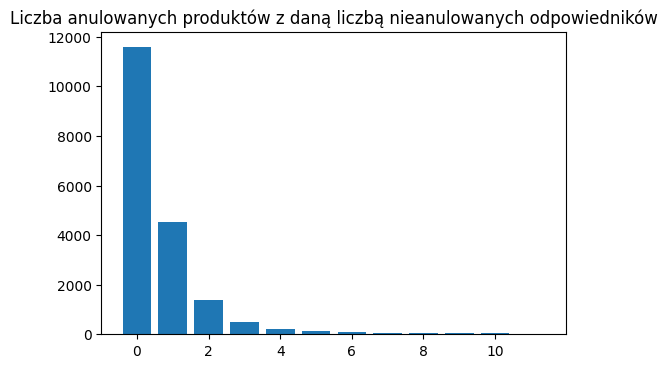

In [859]:
plt.bar(list(range(12)), duplicate_amounts[:12])
plt.title("Liczba anulowanych produktów z daną liczbą nieanulowanych odpowiedników")
print(f"{sum(duplicate_amounts[1:]) / sum(duplicate_amounts):.3f} z anulowanych produktów ma nieanulowany odpowiednik")

In [764]:
grouped_data = data.groupby('Invoice')

In [765]:
aggregated = {
    "Invoice": [],
    "EarliestInvoiceDate": [],
    "LatestInvoiceDate": [],
    "PriceSum": [],
    "TotalQuantity": [],
    "DifferentProducts": [],
    
    "Manual": [],
    "Discount": [],
    "ManualSum": [],
    "DiscountSum": [],
    "Cancelled": [],
    
    "isBritish": [],

    "MostCommon1Quantity": [],
    "MostCommon2Quantity": [],
    "MostCommon3Quantity": [],
    "MostCommon1Price": [],
    "MostCommon2Price": [],
    "MostCommon3Price": [],

    "MostExpensive1Price": [],
    "MostExpensive2Price": [],
    "MostExpensive3Price": [],
    "MostExpensive1Quantity": [],
    "MostExpensive2Quantity": [],
    "MostExpensive3Quantity": []


}

for group_name, df_group in grouped_data:
    if all(df_group['StockCode'].isin(['M', 'm', 'S', 'B', 'D'])):
        continue
    assert not any(df_group['StockCode'] == 'S')

    products = ~df_group['StockCode'].isin(['M', 'm', 'D'])

    assert all(df_group['Invoice'] == group_name)
    aggregated['Invoice'].append(group_name)

    aggregated['isBritish'].append(df_group['Country'].iloc[0] == 'United Kingdom')
    
    group_invoice_dates = df_group['InvoiceDate'].sort_values()
    aggregated['EarliestInvoiceDate'].append(group_invoice_dates.iloc[0])
    aggregated['LatestInvoiceDate'].append(group_invoice_dates.iloc[-1])

    aggregated['PriceSum'].append((df_group['Price'] * df_group['Quantity']).sum())
    aggregated['TotalQuantity'].append(df_group['Quantity'].sum())
    aggregated['DifferentProducts'].append(products.value_counts()[True])

    sorted_group = df_group[products].sort_values(by='Quantity',  ascending=True)
    aggregated['MostCommon1Quantity'].append(sorted_group['Quantity'].iloc[0])
    aggregated['MostCommon1Price'].append(sorted_group['Price'].iloc[0])
    if len(sorted_group) > 2:
        aggregated['MostCommon3Quantity'].append(sorted_group['Quantity'].iloc[2])
        aggregated['MostCommon3Price'].append(sorted_group['Price'].iloc[2])

    else:
        aggregated['MostCommon3Quantity'].append(0)
        aggregated['MostCommon3Price'].append(0)

    if len(sorted_group) > 1:
        aggregated['MostCommon2Quantity'].append(sorted_group['Quantity'].iloc[1])
        aggregated['MostCommon2Price'].append(sorted_group['Price'].iloc[1])

    else:
        aggregated['MostCommon2Quantity'].append(0)
        aggregated['MostCommon2Price'].append(0)

    sorted_by_prices = df_group[products].sort_values(by='Price', ascending=True)
    aggregated['MostExpensive1Price'].append(sorted_by_prices['Price'].iloc[0])
    aggregated['MostExpensive1Quantity'].append(sorted_by_prices['Quantity'].iloc[0])
    if len(sorted_by_prices) > 2:
        aggregated['MostExpensive3Price'].append(sorted_by_prices['Price'].iloc[2])
        aggregated['MostExpensive3Quantity'].append(sorted_by_prices['Quantity'].iloc[2])
    else:
        aggregated['MostExpensive3Price'].append(0)
        aggregated['MostExpensive3Quantity'].append(0)
    if len(sorted_by_prices) > 1:
        aggregated['MostExpensive2Price'].append(sorted_by_prices['Price'].iloc[1])
        aggregated['MostExpensive2Quantity'].append(sorted_by_prices['Quantity'].iloc[1])
    else:
        aggregated['MostExpensive2Price'].append(0)
        aggregated['MostExpensive2Quantity'].append(0)

    aggregated['Manual'].append(0)
    aggregated['Discount'].append(0)
    aggregated['ManualSum'].append(0)
    aggregated['DiscountSum'].append(0)

    stock_code_idx = list(df_group.columns).index('StockCode')
    price_idx = list(df_group.columns).index('Price')
    quantity_idx = list(df_group.columns).index('Price')
    
    for row in df_group.values:
        if row[stock_code_idx] in {'M', 'm'}:
            aggregated['Manual'][-1] += 1
            aggregated['ManualSum'][-1] += row[price_idx] * row[quantity_idx]
        elif row[stock_code_idx] == 'D':
            aggregated['Discount'][-1] += 1
            aggregated['DiscountSum'][-1] += row[price_idx] * row[quantity_idx]
        
    aggregated['PriceSum'][-1] -= aggregated['DiscountSum'][-1] * 2

    aggregated['Cancelled'].append(str(group_name)[0] == 'C')

In [766]:
old_agg_data = pd.DataFrame(aggregated)
old_agg_data.columns

Index(['Invoice', 'EarliestInvoiceDate', 'LatestInvoiceDate', 'PriceSum',
       'TotalQuantity', 'DifferentProducts', 'Product1Quantity',
       'Product2Quantity', 'Product3Quantity', 'Manual', 'Discount',
       'ManualSum', 'DiscountSum', 'Cancelled'],
      dtype='object')

In [767]:
print(len(old_agg_data))
print(len(old_agg_data.drop_duplicates(subset=['PriceSum', 'TotalQuantity'], keep=False)))
# old_agg_data = old_agg_data.drop_duplicates(subset=['PriceSum'], keep=False)
# old_agg_data = old_agg_data.drop_duplicates(subset=['TotalQuantity'], keep=False)
print(len(old_agg_data))
agg_data = old_agg_data

# agg_data = old_agg_data.drop_duplicates(subset=['PriceSum', 'TotalQuantity'], keep=False)

52734
38203
52734


In [768]:
ready_data = agg_data.drop(columns=['Invoice', 'EarliestInvoiceDate', 'LatestInvoiceDate'])
# 'Manual', 'ManualSum', 'Discount', 'DiscountSum', 'EarliestInvoiceDate', 'LatestInvoiceDate', 'PriceSum'
ready_data['InvoiceDate'] = agg_data['EarliestInvoiceDate'].dt.month * 31 + agg_data['EarliestInvoiceDate'].dt.day
ready_data['InvoiceHour'] = agg_data['EarliestInvoiceDate'].dt.hour

In [769]:
train_data, valid_data = train_test_split(ready_data, random_state=421)
train_X, train_y = train_data.drop(columns=['Cancelled']), train_data['Cancelled']
valid_X, valid_y = valid_data.drop(columns=['Cancelled']), valid_data['Cancelled']

In [770]:
# plt.hist(train_data['TimeSpent'], bins=list(range(0, 20, 1)));

In [771]:
train_data.corr()

,PriceSum,TotalQuantity,DifferentProducts,Product1Quantity,Product2Quantity,Product3Quantity,Manual,Discount,ManualSum,DiscountSum,Cancelled,InvoiceDate,InvoiceHour
PriceSum,1.000000,0.680329,0.278564,0.676048,0.095094,0.114678,0.005138,-0.058069,0.010433,-0.083942,-0.069726,0.030127,-0.022648
TotalQuantity,0.680329,1.000000,0.127947,0.593928,0.265232,0.287434,0.001498,0.000260,-0.001688,0.003565,-0.072779,0.010259,-0.024220
DifferentProducts,0.278564,0.127947,1.000000,-0.021543,-0.025597,-0.025937,0.059230,-0.003453,0.006486,-0.001878,-0.174802,0.048974,0.042190
Product1Quantity,0.676048,0.593928,-0.021543,1.000000,0.111091,0.079972,-0.004123,0.000344,-0.000679,0.000069,-0.004987,0.006700,-0.009269
Product2Quantity,0.095094,0.265232,-0.025597,0.111091,1.000000,0.542854,-0.005436,-0.000660,-0.000919,-0.000617,-0.016349,0.001461,-0.013736
Product3Quantity,0.114678,0.287434,-0.025937,0.079972,0.542854,1.000000,-0.006232,-0.000736,-0.001069,-0.000685,-0.029953,0.000849,-0.015929
Manual,0.005138,0.001498,0.059230,-0.004123,-0.005436,-0.006232,1.000000,-0.001021,0.112710,-0.000784,-0.000392,0.002803,0.021623
Discount,-0.058069,0.000260,-0.003453,0.000344,-0.000660,-0.000736,-0.001021,1.000000,-0.000150,0.662280,0.025596,0.000711,0.008754
ManualSum,0.010433,-0.001688,0.006486,-0.000679,-0.000919,-0.001069,0.112710,-0.000150,1.000000,-0.000115,0.000605,0.002315,0.001888
DiscountSum,-0.083942,0.003565,-0.001878,0.000069,-0.000617,-0.000685,-0.000784,0.662280,-0.000115,1.000000,0.019675,0.005997,0.004564


In [772]:
train_data['InvoiceDate'].value_counts()

373    348
374    339
380    334
345    283
379    276
      ... 
127     15
156     15
75      13
106     12
68       9
Name: InvoiceDate, Length: 352, dtype: int64

In [773]:
model = xgb.XGBClassifier()
model.fit(train_X, train_y)
pred = model.predict(valid_X)
# print(train_y)

print(cohen_kappa_score(valid_y, pred))
print(accuracy_score(valid_y, pred))
# print(export_text(model))

0.7038475785243581
0.927563713592233


In [774]:
print(len(valid_y))

13184


In [775]:
rand = (np.random.uniform(0, 1, len(valid_y)) > train_data['Cancelled'].value_counts()[False] / len(train_data['Cancelled'])).astype(np.int64)
print(cohen_kappa_score(valid_y, rand))
print(accuracy_score(valid_y, rand))

0.003186711521971586
0.7559162621359223


In [776]:
zeros = np.zeros(len(valid_y))
print(cohen_kappa_score(valid_y, zeros))
print(accuracy_score(valid_y, zeros))

0.0
0.8596783980582524
